---
**License**

 NC_ccl_xcor_dndz

 Sat Dec 23 12:00:00 2023\
 Copyright  2023\
 Luigi Lucas de Carvalho Silva <luigi.lcsilva@gmail.com>

---
---

 NC_ccl_xcor_dndz\
 Copyright (C) 2023 Luigi Lucas de Carvalho Silva <luigi.lcsilva@gmail.com>

 numcosmo is free software: you can redistribute it and/or modify it
 under the terms of the GNU General Public License as published by the
 Free Software Foundation, either version 3 of the License, or
 (at your option) any later version.

 numcosmo is distributed in the hope that it will be useful, but
 WITHOUT ANY WARRANTY; without even the implied warranty of
 MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.
 See the GNU General Public License for more details.

 You should have received a copy of the GNU General Public License along
 with this program.  If not, see <http://www.gnu.org/licenses/>.
 
---

## Startups and Packages

First of all, let us import some useful packages.

In [1]:
######## NUM COSMO ########
from numcosmo_py import Ncm, Nc

######## CCL ########
import pyccl as pyccl

######## GENERAL ########
import sys
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline
import time

######## COMPARISSON ########
from numcosmo_py.ccl.nc_ccl import CCLParams, create_nc_obj

ccl_params_class = CCLParams()
# ccl_params_class.set_high_prec_params()

#create_nc_obj: Create a NumCosmo object from a CCL cosmology.
#ccl_params_class.set_high_prec_params(): Set CCL cosmology to high precision.

Now, let us get the libraries versions.

In [2]:
### GETTING NUMCOSMO VERSION
# dir(Ncm) # Show the library functions.

ncmpath = Ncm.__path__[0]
ncmpath = ncmpath.replace("/NumCosmoMath-1.0.typelib", "")
buildfile = open(ncmpath + "/build_cfg.h", "r").readlines()

for line in buildfile:
    if "NUMCOSMO_VERSION" in line:
        ncversion = line
        for ch in ["#define", "NUMCOSMO_VERSION", '"', "\n", "  "]:
            if ch in ncversion:
                ncversion = ncversion.replace(ch, "")
print("NumCosmo Version: " + ncversion)

### GETTING CCL VERSION
print("CCL Version: " + str(pyccl.__version__))

NumCosmo Version: 0.22.0
CCL Version: 3.1


Now, let us initialize the NumCosmo library.

In [3]:
Ncm.cfg_init()
Ncm.cfg_set_log_handler(lambda msg: sys.stdout.write(msg) and sys.stdout.flush())

## Cosmological parameters

In [4]:
# Fixed parameters.
Neff_massless_neutrinos = 3.0  # Effective number of massless neutrinos present. For the massive case, the Neff is
# defined with the other parameters in the cosmology array.
T_CMB = 2.726  # The CMB temperature today.

######### COSMOLOGIES ##########
# Reference: https://arxiv.org/pdf/1812.05995.pdf, Table 3 and Table 4.
# Order of parameters: Omega_c, Omega_b, Omega_v, h, sigma8, n_s, w0, wa, Neff, m_nu
CCL_cosmologies = {}
### MASSLESS NEUTRINOS ####
CCL_cosmologies["CCL1"] = [
    0.25,
    0.05,
    0.7,
    0.7,
    0.8,
    0.96,
    -1.0,
    0.0,
    Neff_massless_neutrinos,
    0,
]  # flat ΛCDM
CCL_cosmologies["CCL2"] = [
    0.25,
    0.05,
    0.7,
    0.7,
    0.8,
    0.96,
    -0.9,
    0.0,
    Neff_massless_neutrinos,
    0,
]  # wCDM
CCL_cosmologies["CCL3"] = [
    0.25,
    0.05,
    0.7,
    0.7,
    0.8,
    0.96,
    -0.9,
    0.1,
    Neff_massless_neutrinos,
    0,
]  # wCDM
# CCL_cosmologies["CCL4"] = [0.25, 0.05, 0.65, 0.7, 0.8, 0.96, -0.9, 0.1, Neff_massless_neutrinos, 0] #open wCDM    # Bad results for k different from 0.
# CCL_cosmologies["CCL5"] = [0.25, 0.05, 0.75, 0.7, 0.8, 0.96, -0.9, 0.1, Neff_massless_neutrinos, 0] #closed wCDM  # Bad results for k different from 0.
# CCL_cosmologies["CCL6"] = [0.3, 0.0, 0.7, 0.7, 0.8, 0.96, -1.0, 0.0, Neff_massless_neutrinos, 0]    #flat ΛCDM    # Kernel dying for this cosmology
CCL_cosmologies["WMAP7"] = [
    0.2265,
    0.0455,
    0.728,
    0.704,
    0.810,
    0.967,
    -1.0,
    0.0,
    Neff_massless_neutrinos,
    0,
]  # flat ΛCDM
CCL_cosmologies["Planck2013"] = [
    0.269,
    0.0490,
    0.682,
    0.671,
    0.834,
    0.962,
    -1.0,
    0.0,
    Neff_massless_neutrinos,
    0,
]  # flat ΛCDM
### MASSIVE NEUTRINOS ####
# Obs.: The create_nc_obj from nc_ccl.py is not updated for the new version of CCL. So, we cannot include massive neutrinos right now.
# CCL_cosmologies["CCL7"] = [0.25, 0.05, 0.7, 0.7, 0.8, 0.96, -1.0, 0.0, 3.013, [0.04,0,0]]  #flat ΛCDM, mν

names = []
for key, value in CCL_cosmologies.items():
    names.append(key)

# Defining the tracers

In [5]:
###################### TIME START ##########################
start = time.time()

######## REDSHIFT DISTRIBUTION OF OBJECTS FROM HISTOGRAM ########
### Getting the redshift distribution for the objects from the CCL bin1_histo and bin2_histo files.
# Source: https://github.com/LSSTDESC/CCL/tree/master/benchmarks/data -- Files bin1_histo.txt and bin2_histo.txt
# Used in the CCL article: https://arxiv.org/pdf/1812.05995.pdf

# Loading the data. The txt files have 2 columns. The first column contains the redshift values,
# and the second column contains the dndz values.
bin1_histo = np.loadtxt(
    "./data/bin1_histo.txt", delimiter=" "
)  # Loading the first histogram.
len_bin1_histo = bin1_histo.shape[0]  # Getting the number of lines.

bin2_histo = np.loadtxt(
    "./data/bin2_histo.txt", delimiter=" "
)  # Loading the second histogram.
len_bin2_histo = bin2_histo.shape[0]  # Getting the number of lines.

# Saving the redshift in two lists.
z_bin1_histo = []
z_bin2_histo = []

for i in range(len_bin1_histo):
    z_bin1_histo.append(bin1_histo[i][0])

for i in range(len_bin2_histo):
    z_bin2_histo.append(bin2_histo[i][0])

z_bin1_histo_np = np.array(z_bin1_histo)
z_bin2_histo_np = np.array(z_bin2_histo)

# Checking if the histograms have the same number of lines, and if the redshifts values are equal.
if len_bin1_histo != len_bin2_histo:
    print("Different histograms size!")
else:
    print("Equal histograms size! \n")
    z_histo_diff = [z_bin1_histo[i] - z_bin2_histo[i] for i in range(len_bin1_histo)]
    count_z_histo_diff_nonzero = np.count_nonzero(z_histo_diff)
    if count_z_histo_diff_nonzero == 0:
        print("Redshifts are also equal!")

# Saving the dndz values in two lists.
dndz_bin1_histo = []
dndz_bin2_histo = []
for i in range(len_bin1_histo):
    dndz_bin1_histo.append(bin1_histo[i][1])

for i in range(len_bin2_histo):
    dndz_bin2_histo.append(bin2_histo[i][1])

dndz_bin1_histo_np = np.array(dndz_bin1_histo)
dndz_bin2_histo_np = np.array(dndz_bin2_histo)

###################### TIME END ##########################
end = time.time()
print(str(end - start) + "s")

Equal histograms size! 

Redshifts are also equal!
0.003288745880126953s


In [6]:
######## ANALYTICAL REDSHIFT DISTRIBUTION OF OBJECTS ########
### Getting the analytical redshift distribution for the objects as used in CCL article.
# Source: https://github.com/LSSTDESC/CCL/tree/master/benchmarks/data -- Files bin1_histo.txt and bin2_histo.txt
# Used in the CCL article: https://arxiv.org/pdf/1812.05995.pdf

# Redshift values.
z_analytical_max = math.ceil(max(z_bin1_histo))
z_analytical = np.arange(0, z_analytical_max, 0.001)

# Below, I will multiply the gaussian distributions by the maximum value of the bin1_histo distribution, just for better visualization.
# The libraries used here do the normalization automatically.
peak_factor = max(dndz_bin1_histo)

# Analytical redshift distributions.
analytical_zmean_1 = 1.0
analytical_sigz_1 = 0.15
analytical_zmean_2 = 1.5
analytical_sigz_2 = 0.15
dndz_analytical_1 = peak_factor * np.exp(
    -0.5 * ((z_analytical - analytical_zmean_1) / analytical_sigz_1) ** 2
)
dndz_analytical_2 = peak_factor * np.exp(
    -0.5 * ((z_analytical - analytical_zmean_2) / analytical_sigz_2) ** 2
)

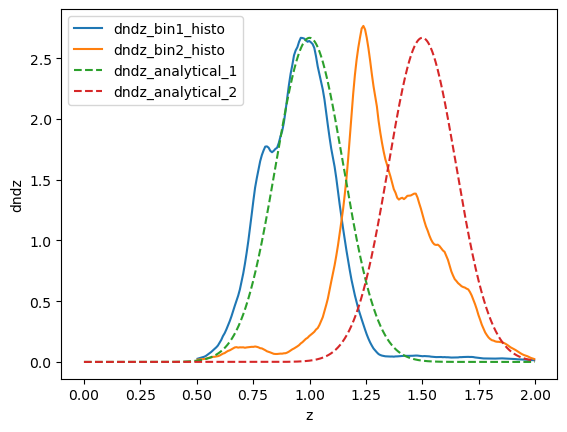

In [7]:
######## PLOT OF THE REDSHIFT DISTRIBUTIONS OF OBJECTS ########
plt.plot(z_bin1_histo, dndz_bin1_histo, label="dndz_bin1_histo")
plt.plot(z_bin2_histo, dndz_bin2_histo, label="dndz_bin2_histo")
plt.plot(z_analytical, dndz_analytical_1, label="dndz_analytical_1", linestyle="dashed")
plt.plot(z_analytical, dndz_analytical_2, label="dndz_analytical_2", linestyle="dashed")
plt.legend()
plt.xlabel("z")
plt.ylabel("dndz")
plt.show()

# Defining the function for the comparison

In [8]:
# Obs.: Problem with the "mass_function" in the nc_ccl.py file. I commented it there.
def compare_galaxy_galaxy_angular_cl(
    Omega_c,
    Omega_b,
    Omega_v,
    h,
    sigma8,
    n_s,
    w0,
    wa,
    Neff,
    m_nu,
    z1,
    z2,
    dndz1,
    dndz2,
    ells,
):
    """
    Compare the angular power spectrum of two galaxy type probes.

    Numcosmo apparently can't skip l's. It have just lmin and lmax as parameters in the angular power spectrum computation, in a continuous
    way.
    """
    ##### GENERAL #####
    # Set Omega_K in a consistent way
    Omega_k = 1.0 - Omega_c - Omega_b - Omega_v

    ##### COSMOLOGIES #####
    # Defining the CCL cosmology.
    ccl_cosmo = pyccl.Cosmology(
        Omega_c=Omega_c,
        Omega_b=Omega_b,
        Neff=Neff,
        m_nu=m_nu,
        h=h,
        n_s=n_s,
        Omega_k=Omega_k,
        Omega_g=None,
        w0=w0,
        wa=wa,
        sigma8=sigma8,
        transfer_function="eisenstein_hu",
        T_CMB=T_CMB,
        matter_power_spectrum="linear",
    )

    # Defining the NumCosmo cosmology.
    nc_cosmo = create_nc_obj(ccl_cosmo)
    # More info: https://github.com/NumCosmo/NumCosmo/blob/master/numcosmo_py/ccl/nc_ccl.py

    ##### CCL POWER SPECTRUM COMPUTATION #####
    # Setting the galaxy bias to unity.
    unity_bias_1 = np.array([1 for i in np.arange(0, len(z1))])
    unity_bias_2 = np.array([1 for i in np.arange(0, len(z2))])

    # Initialize tracers in CCL.
    trcs_ccl = dict()
    trcs_ccl["g1"] = pyccl.NumberCountsTracer(
        cosmo=ccl_cosmo,
        dndz=(z1, dndz1),
        bias=(z1, unity_bias_1),
        mag_bias=None,
        has_rsd=False,
    )
    trcs_ccl["g2"] = pyccl.NumberCountsTracer(
        cosmo=ccl_cosmo,
        dndz=(z2, dndz2),
        bias=(z2, unity_bias_2),
        mag_bias=None,
        has_rsd=False,
    )

    # Computing the angular power spectrum in CCL.
    ccl_cl_cross = pyccl.angular_cl(ccl_cosmo, trcs_ccl["g1"], trcs_ccl["g2"], ells)
    ccl_cl_auto1 = pyccl.angular_cl(ccl_cosmo, trcs_ccl["g1"], trcs_ccl["g1"], ells)
    ccl_cl_auto2 = pyccl.angular_cl(ccl_cosmo, trcs_ccl["g2"], trcs_ccl["g2"], ells)

    # Converting the results to Numpy arrays.
    ccl_cl_cross_np = np.array(ccl_cl_cross)
    ccl_cl_auto1_np = np.array(ccl_cl_auto1)
    ccl_cl_auto2_np = np.array(ccl_cl_auto2)

    ##### NUMCOSMO POWER SPECTRUM COMPUTATION #####
    # Defining the z and dndz as vectors in NumCosmo.
    v_z1 = Ncm.Vector.new_array(z1)
    v_z2 = Ncm.Vector.new_array(z2)
    v_pz1 = Ncm.Vector.new_array(dndz1)
    v_pz2 = Ncm.Vector.new_array(dndz2)

    # Obtaining the spline in NumCosmo.
    # Parameters Ncm.SplineCubicNotaknot.new_full:
    # xv: NcmVector of knots
    # yv: NcmVector of the values of the function, to be interpolated, computed at xv
    # init: TRUE to prepare the new NcmSpline or FALSE to not prepare it
    s_pz1 = Ncm.SplineCubicNotaknot.new_full(v_z1, v_pz1, True)
    s_pz2 = Ncm.SplineCubicNotaknot.new_full(v_z2, v_pz2, True)

    # Defining the kernels in NumCosmo.
    nc_g1 = None
    nc_g2 = None
    # Parameters Nc.XcorLimberKernelGal.new:
    # zmin: a gdouble.
    # zmax: a gdouble.
    # np: number of points in the interpolation.
    # nbarm1: a gdouble, noise spectrum.
    # dn_dz: a NcmSpline.
    # dist: a NcDistance.
    # domagbias: whether to do magnification bias.
    nc_g1 = Nc.XcorLimberKernelGal.new(
        z1[0], z1[-1], 1, 0.0, s_pz1, nc_cosmo.dist, False
    )
    nc_g2 = Nc.XcorLimberKernelGal.new(
        z2[0], z2[-1], 1, 0.0, s_pz2, nc_cosmo.dist, False
    )

    # Pushing the objects to mset in NumCosmo.
    mset = Ncm.MSet.empty_new()
    mset.set(nc_cosmo.cosmo)
    mset.push(nc_g1)
    mset.push(nc_g2)

    # Computing the angular power spectrum in NumCosmo.
    # Parameters nc_xcor_new:
    # nc_xcor_new (NcDistance *dist, NcmPowspec *ps, NcXcorLimberMethod meth);
    # Two methods are available to compute Limber-approximated integrals: independent GSL numerical integration or
    # vector integration using Sundials's CVode algorithm.
    xcor = Nc.Xcor.new(nc_cosmo.dist, nc_cosmo.ps_ml, Nc.XcorLimberMethod.GSL)
    ####
    len_l = ells.size

    vp_cross = Ncm.Vector.new(len_l)
    vp_auto1 = Ncm.Vector.new(len_l)
    vp_auto2 = Ncm.Vector.new(len_l)
    ####
    xcor.prepare(nc_cosmo.cosmo)
    ####
    # Parameters xcor.limber:
    # xc -> a NcXcor
    # xclk1 -> a NcXcorLimberKernel
    # xclk2 -> a NcXcorLimberKernel
    # cosmo -> a NcHICosmo
    # lmin -> a guint
    # lmax -> a guint
    # vp -> a NcmVector
    if nc_g1 and nc_g2:
        nc_g1.prepare(nc_cosmo.cosmo)
        nc_g2.prepare(nc_cosmo.cosmo)
        xcor.limber(nc_g1, nc_g2, nc_cosmo.cosmo, ells[0], ells[-1], vp_cross)
        xcor.limber(nc_g1, nc_g1, nc_cosmo.cosmo, ells[0], ells[-1], vp_auto1)
        xcor.limber(nc_g2, nc_g2, nc_cosmo.cosmo, ells[0], ells[-1], vp_auto2)

    # Getting the results and converting them to Numpy arrays.
    nc_cl_cross = [Ncm.Vector.get(vp_cross, i) for i in np.arange(0, len_l)]
    nc_cl_auto1 = [Ncm.Vector.get(vp_auto1, i) for i in np.arange(0, len_l)]
    nc_cl_auto2 = [Ncm.Vector.get(vp_auto2, i) for i in np.arange(0, len_l)]

    nc_cl_cross_np = np.array(nc_cl_cross)
    nc_cl_auto1_np = np.array(nc_cl_auto1)
    nc_cl_auto2_np = np.array(nc_cl_auto2)

    ##### RELATIVE DIFFERENCE COMPUTATION #####
    relative_diff_cross = (nc_cl_cross_np - ccl_cl_cross_np) / nc_cl_cross_np
    relative_diff_auto1 = (nc_cl_auto1_np - ccl_cl_auto1_np) / nc_cl_auto1_np
    relative_diff_auto2 = (nc_cl_auto2_np - ccl_cl_auto2_np) / nc_cl_auto2_np

    ### ACCURACY METRIC ###
    ## CROSS
    # Source: page 28, https://arxiv.org/pdf/1812.05995.pdf
    # For cross PS of fields a and b, we must have Caa, Cbb and Cab of the independent realization.
    # For auto PS of field a, Caa, Cbb and Cab can be set to the same value.

    Cab = ccl_cl_cross_np

    ### The reference to compute sig_l
    Caa_ref = nc_cl_auto1_np
    Cbb_ref = nc_cl_auto2_np
    Cab_ref = nc_cl_cross_np

    intern_fact = (Caa_ref * Cbb_ref + Cab_ref**2) / (2 * ells + 1)
    sig_l = np.sqrt(intern_fact)

    A_acc_cross = np.abs((Cab - Cab_ref) / sig_l)

    ## AUTO 1
    # For cross PS of fields a and b, we must have Caa, Cbb and Cab of the independent realization.
    # For auto PS of field a, Caa, Cbb and Cab can be set to the same value.

    Cab = ccl_cl_auto1_np

    ### The reference to compute sig_l
    Caa_ref = nc_cl_auto1_np
    Cbb_ref = nc_cl_auto1_np
    Cab_ref = nc_cl_auto1_np

    intern_fact = (Caa_ref * Cbb_ref + Cab_ref**2) / (2 * ells + 1)
    sig_l = np.sqrt(intern_fact)

    A_acc_auto1 = np.abs((Cab - Cab_ref) / sig_l)

    ## AUTO 2
    # For cross PS of fields a and b, we must have Caa, Cbb and Cab of the independent realization.
    # For auto PS of field a, Caa, Cbb and Cab can be set to the same value.

    Cab = ccl_cl_auto2_np

    ### The reference to compute sig_l
    Caa_ref = nc_cl_auto2_np
    Cbb_ref = nc_cl_auto2_np
    Cab_ref = nc_cl_auto2_np

    intern_fact = (Caa_ref * Cbb_ref + Cab_ref**2) / (2 * ells + 1)
    sig_l = np.sqrt(intern_fact)

    A_acc_auto2 = np.abs((Cab - Cab_ref) / sig_l)

    return (
        ccl_cl_cross_np,
        ccl_cl_auto1_np,
        ccl_cl_auto2_np,
        nc_cl_cross_np,
        nc_cl_auto1_np,
        nc_cl_auto2_np,
        relative_diff_cross,
        relative_diff_auto1,
        relative_diff_auto2,
        A_acc_cross,
        A_acc_auto1,
        A_acc_auto2,
    )

# Doing the Galaxy-Galaxy comparison for the histogram case

In [9]:
#### Defining the array of ells
lmax = 3000
ells = np.arange(lmax + 1)
ells = ells[1:]
print("ells= " + str(ells))

### Defining the distributions
z1 = z_bin1_histo_np
z2 = z_bin2_histo_np
dndz1 = dndz_bin1_histo_np
dndz2 = dndz_bin2_histo_np

ells= [   1    2    3 ... 2998 2999 3000]


A_acc_auto1 max CCL2 = [0.13032286 0.13815723 0.15298824 0.15976272 0.1722253  0.18343295
 0.18976064 0.1898543  0.19339684 0.19347026]

A_acc_auto1 max value position CCL2 = [ 519  586  730  798  931 1063 1147 1148 1189 1190]

A_acc_auto1 max CCL3 = [0.11813854 0.12057085]

A_acc_auto1 max value position CCL3 = [468 487]



/home/sandro/Projects/CCL/build/lib/pyccl/cells.py:68: CCLWarning: CCL does not properly use the hyperspherical Bessel functions when computing angular power spectra in non-flat cosmologies!
  warnings.warn(


[None]

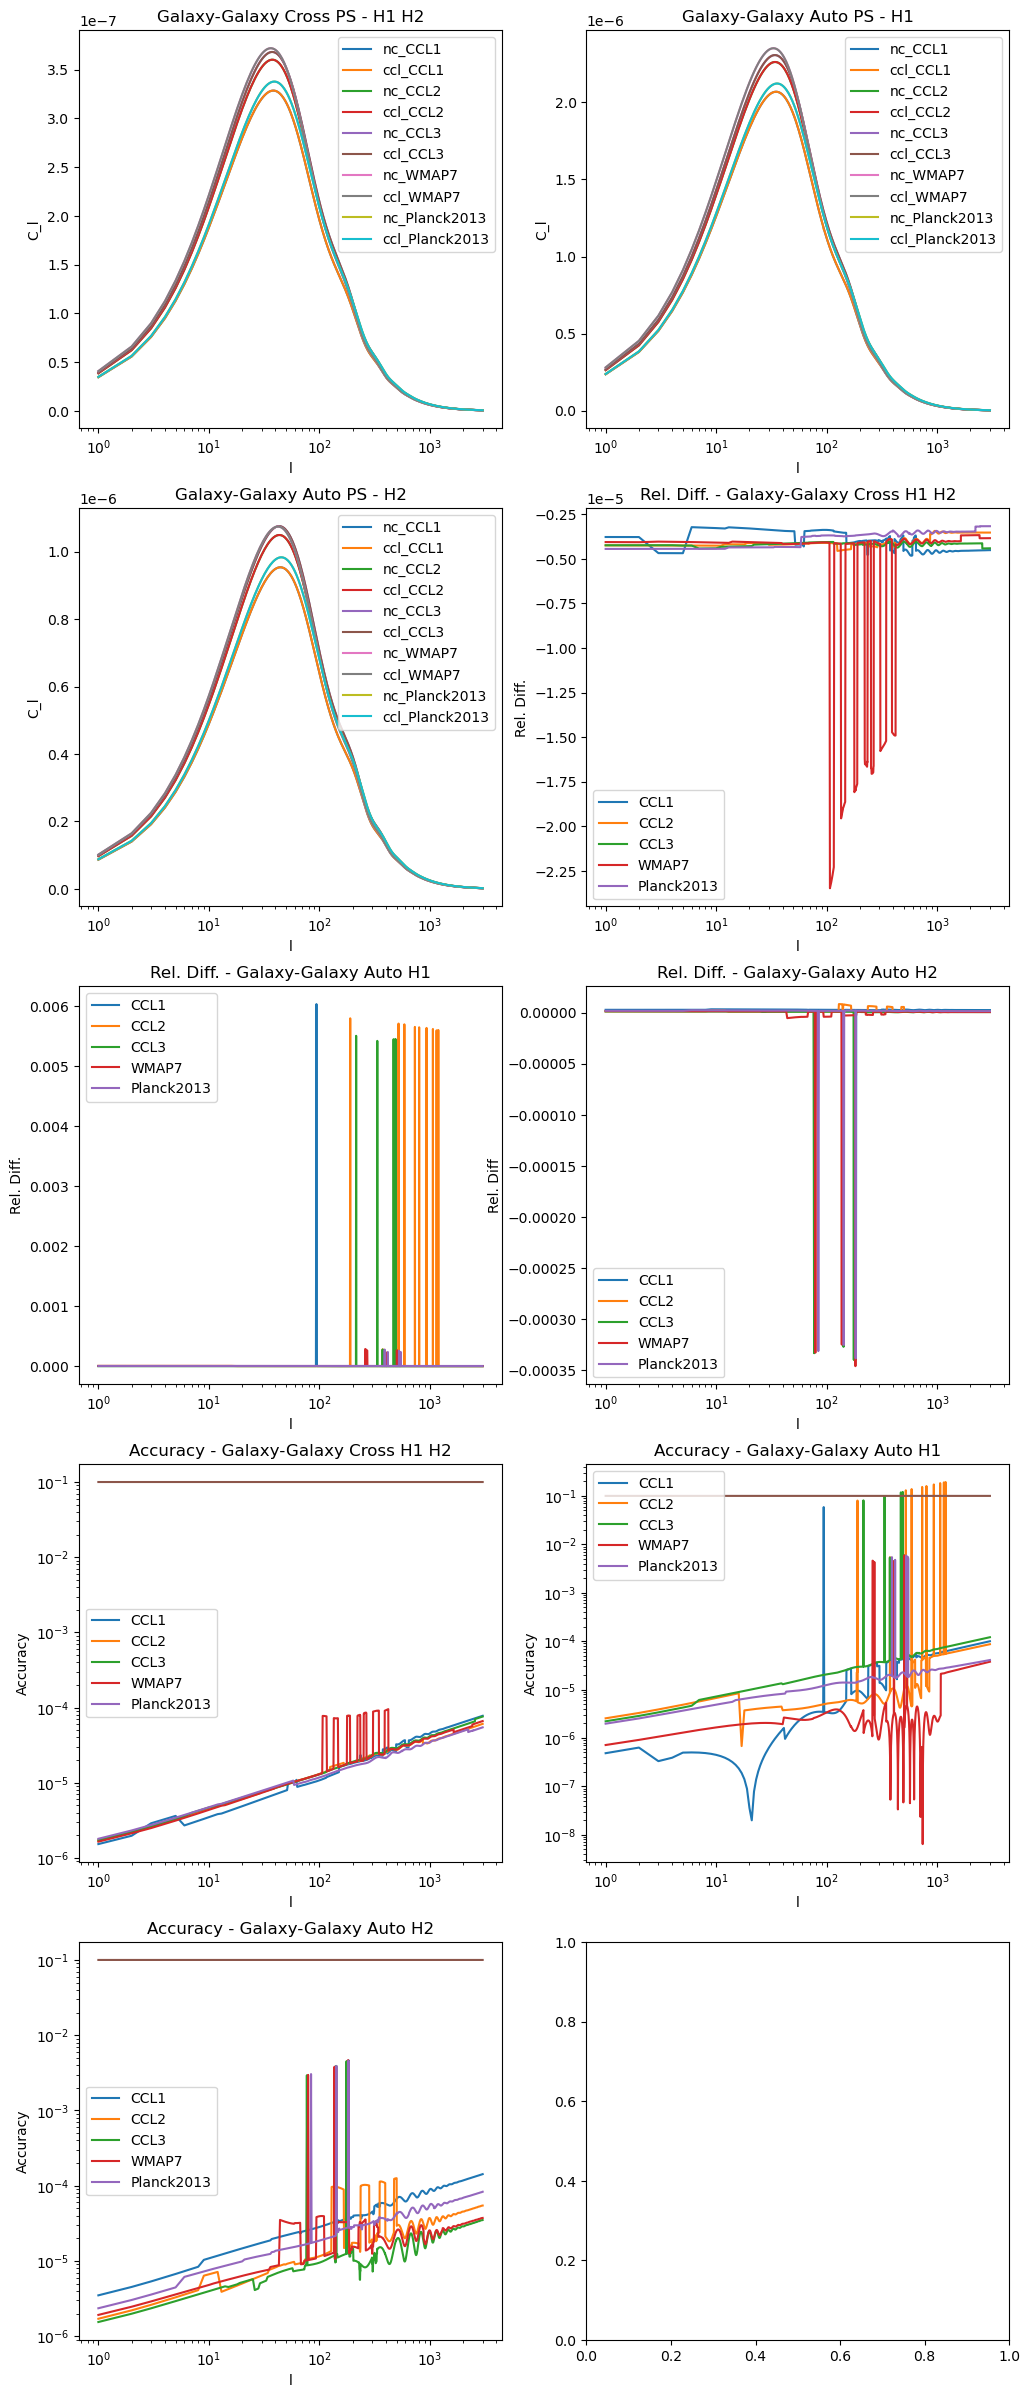

In [10]:
###### Defining some dictionaries to store some values ########
CCL_cl_cross = {}
CCL_cl_auto1 = {}
CCL_cl_auto2 = {}
NC_cl_cross = {}
NC_cl_auto1 = {}
NC_cl_auto2 = {}
REL_DIFF_cross = {}
REL_DIFF_auto1 = {}
REL_DIFF_auto2 = {}
ACC_cross = {}
ACC_auto1 = {}
ACC_auto2 = {}

###### Defining the figure
fig, axs = plt.subplots(5, 2, figsize=(12, 30))

###### Running the loop
i = 0
for cosmology in names:
    Omega_c = CCL_cosmologies[cosmology][0]
    Omega_b = CCL_cosmologies[cosmology][1]
    Omega_v = CCL_cosmologies[cosmology][2]
    h = CCL_cosmologies[cosmology][3]
    sigma8 = CCL_cosmologies[cosmology][4]
    n_s = CCL_cosmologies[cosmology][5]
    w0 = CCL_cosmologies[cosmology][6]
    wa = CCL_cosmologies[cosmology][7]
    Neff = CCL_cosmologies[cosmology][8]
    m_nu = CCL_cosmologies[cosmology][9]

    name = cosmology

    (
        CCL_cl_cross[name],
        CCL_cl_auto1[name],
        CCL_cl_auto2[name],
        NC_cl_cross[name],
        NC_cl_auto1[name],
        NC_cl_auto2[name],
        REL_DIFF_cross[name],
        REL_DIFF_auto1[name],
        REL_DIFF_auto2[name],
        ACC_cross[name],
        ACC_auto1[name],
        ACC_auto2[name],
    ) = compare_galaxy_galaxy_angular_cl(
        Omega_c,
        Omega_b,
        Omega_v,
        h,
        sigma8,
        n_s,
        w0,
        wa,
        Neff,
        m_nu,
        z1,
        z2,
        dndz1,
        dndz2,
        ells,
    )

    axs[0, 0].plot(ells, NC_cl_cross[name], label="nc_" + name)
    axs[0, 0].plot(ells, CCL_cl_cross[name], label="ccl_" + name)

    axs[0, 1].plot(ells, NC_cl_auto1[name], label="nc_" + name)
    axs[0, 1].plot(ells, CCL_cl_auto1[name], label="ccl_" + name)

    axs[1, 0].plot(ells, NC_cl_auto2[name], label="nc_" + name)
    axs[1, 0].plot(ells, CCL_cl_auto2[name], label="ccl_" + name)

    axs[1, 1].plot(ells, REL_DIFF_cross[name], label=name)

    axs[2, 0].plot(ells, REL_DIFF_auto1[name], label=name)

    axs[2, 1].plot(ells, REL_DIFF_auto2[name], label=name)

    axs[3, 0].plot(ells, ACC_cross[name], label=name)

    axs[3, 1].plot(ells, ACC_auto1[name], label=name)

    axs[4, 0].plot(ells, ACC_auto2[name], label=name)

    if ACC_cross[name].max() > 0.1:
        print(
            "A_acc_cross max "
            + name
            + " = "
            + str(ACC_cross[name][ACC_cross[name] > 0.1])
            + "\n"
        )
        print(
            "A_acc_cross max value position "
            + name
            + " = "
            + str(np.where(ACC_cross[name] > 0.1)[0])
            + "\n"
        )
    if ACC_auto1[name].max() > 0.1:
        print(
            "A_acc_auto1 max "
            + name
            + " = "
            + str(ACC_auto1[name][ACC_auto1[name] > 0.1])
            + "\n"
        )
        print(
            "A_acc_auto1 max value position "
            + name
            + " = "
            + str(np.where(ACC_auto1[name] > 0.1)[0])
            + "\n"
        )
    if ACC_auto2[name].max() > 0.1:
        print(
            "A_acc_auto2 max "
            + name
            + " = "
            + str(ACC_auto2[name][ACC_auto2[name] > 0.1])
            + "\n"
        )
        print(
            "A_acc_auto2 max value position "
            + name
            + " = "
            + str(np.where(ACC_auto2[name] > 0.1)[0])
            + "\n"
        )

    i += 1

axs[0, 0].set_title("Galaxy-Galaxy Cross PS - H1 H2")
axs[0, 0].legend()
axs[0, 0].set(xlabel="l", ylabel="C_l")
axs[0, 0].set(xscale="log")

axs[0, 1].set_title("Galaxy-Galaxy Auto PS - H1")
axs[0, 1].legend()
axs[0, 1].set(xlabel="l", ylabel="C_l")
axs[0, 1].set(xscale="log")

axs[1, 0].set_title("Galaxy-Galaxy Auto PS - H2")
axs[1, 0].legend()
axs[1, 0].set(xlabel="l", ylabel="C_l")
axs[1, 0].set(xscale="log")

axs[1, 1].set_title("Rel. Diff. - Galaxy-Galaxy Cross H1 H2")
axs[1, 1].legend()
axs[1, 1].set(xlabel="l", ylabel="Rel. Diff.")
axs[1, 1].set(xscale="log")

axs[2, 0].set_title("Rel. Diff. - Galaxy-Galaxy Auto H1")
axs[2, 0].legend()
axs[2, 0].set(xlabel="l", ylabel="Rel. Diff.")
axs[2, 0].set(xscale="log")

axs[2, 1].set_title("Rel. Diff. - Galaxy-Galaxy Auto H2")
axs[2, 1].legend()
axs[2, 1].set(xlabel="l", ylabel="Rel. Diff")
axs[2, 1].set(xscale="log")

expected_acc = np.empty(len(ells))
expected_acc.fill(0.1)

axs[3, 0].plot(ells, expected_acc)
axs[3, 0].set_title("Accuracy - Galaxy-Galaxy Cross H1 H2")
axs[3, 0].legend()
axs[3, 0].set(xlabel="l", ylabel="Accuracy")
axs[3, 0].set(xscale="log")
axs[3, 0].set(yscale="log")

axs[3, 1].plot(ells, expected_acc)
axs[3, 1].set_title("Accuracy - Galaxy-Galaxy Auto H1")
axs[3, 1].legend()
axs[3, 1].set(xlabel="l", ylabel="Accuracy")
axs[3, 1].set(xscale="log")
axs[3, 1].set(yscale="log")

axs[4, 0].plot(ells, expected_acc)
axs[4, 0].set_title("Accuracy - Galaxy-Galaxy Auto H2")
axs[4, 0].legend()
axs[4, 0].set(xlabel="l", ylabel="Accuracy")
axs[4, 0].set(xscale="log")
axs[4, 0].set(yscale="log")

## Analyzing the problematic points of histogram case

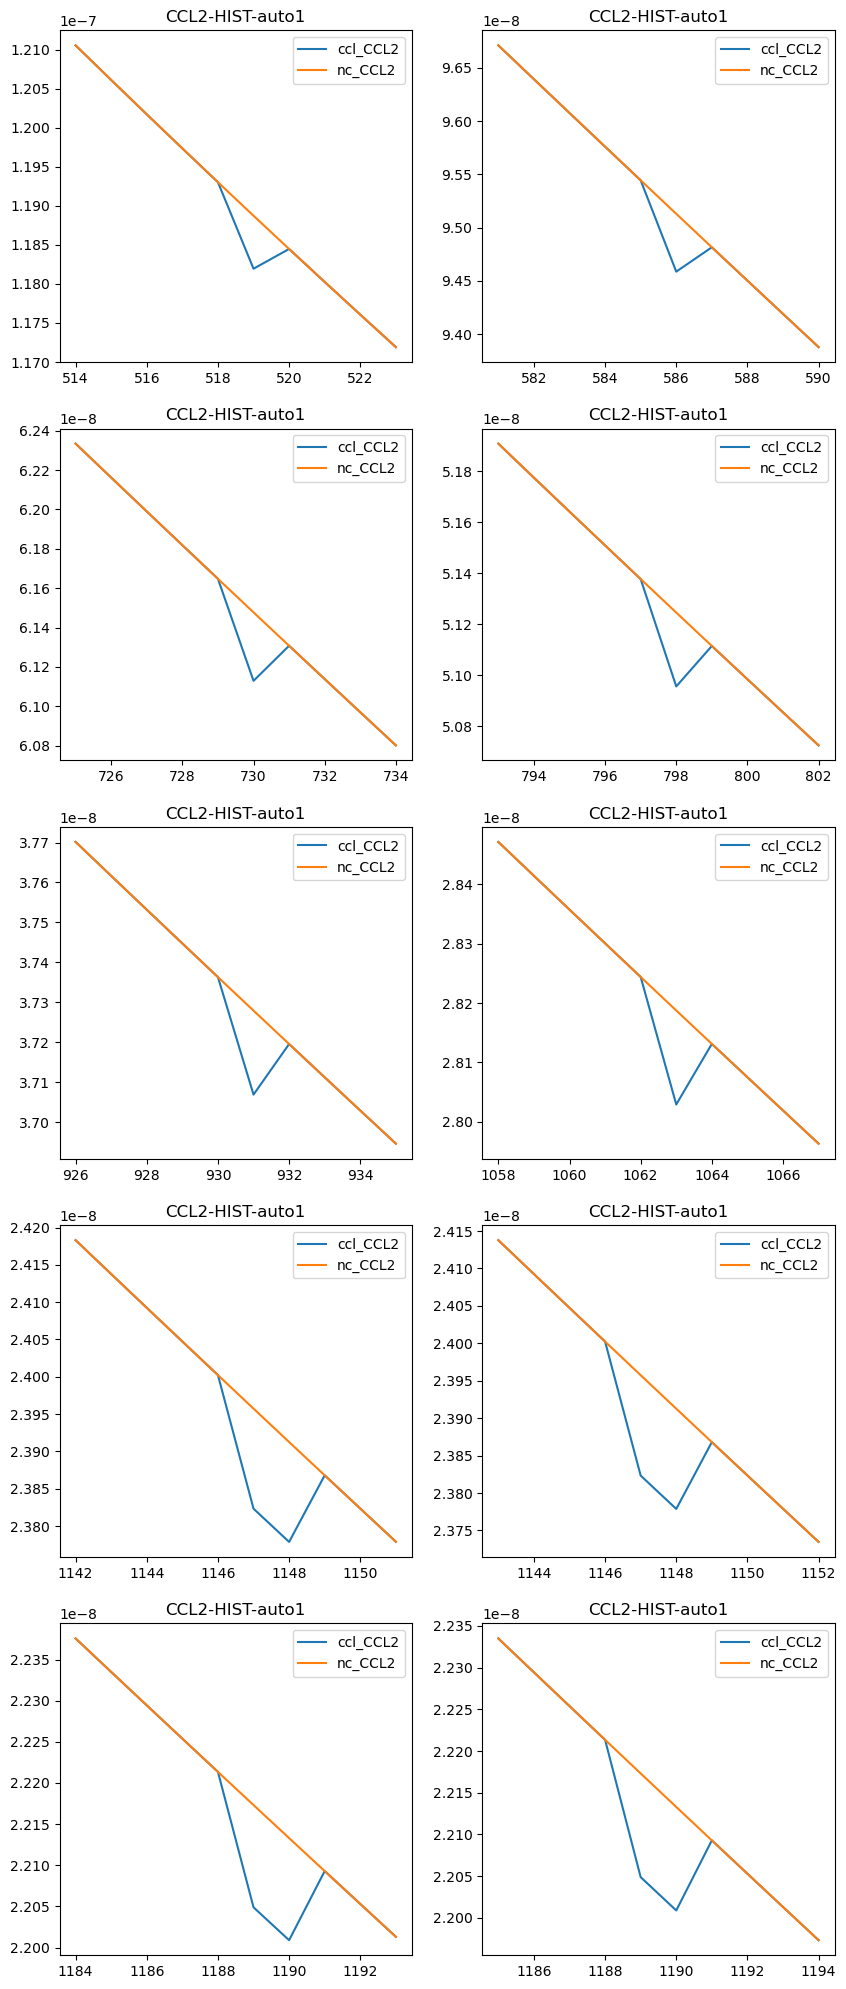

In [11]:
##### CONFIGURATION #####
#### Analysis configuration ###
chosen_cosmo = "CCL2"
chosen_type = "auto1"
chosen_acc_dic = ACC_auto1
chosen_ccl_dic = CCL_cl_auto1
chosen_nc_dic = NC_cl_auto1

problematic_ells = np.where(chosen_acc_dic[chosen_cosmo] > 0.1)[0]

### Plot configuration ###
col_lim = 2
size_config = 5
### Defining the interval around the problematic ell to be plotted ###
plot_interval = 5

######## CODE ########
### Defining the figure and line limits ###
if len(problematic_ells) % col_lim == 0:
    lines_lim = len(problematic_ells) // col_lim
else:
    lines_lim = len(problematic_ells) // col_lim + 1

fig, axs = plt.subplots(
    lines_lim, col_lim, figsize=(col_lim * size_config, lines_lim * size_config)
)

### Running the loop ###
p_ell_index = 0
stop = len(problematic_ells)
for i in np.arange(0, lines_lim, 1):
    for j in np.arange(0, col_lim, 1):
        if p_ell_index < stop:
            p_ell = problematic_ells[p_ell_index]

            x = np.arange(p_ell - plot_interval, p_ell + plot_interval, 1)
            y1 = chosen_ccl_dic[chosen_cosmo][x]
            y2 = chosen_nc_dic[chosen_cosmo][x]

            axs[i, j].plot(x, y1, label="ccl_" + chosen_cosmo)
            axs[i, j].plot(x, y2, label="nc_" + chosen_cosmo)
            axs[i, j].set_title(chosen_cosmo + "-HIST-" + chosen_type)
            axs[i, j].legend()
        p_ell_index += 1


# chosen_interval = np.arange(515,525,1)

# plt.plot(chosen_interval, CCL_cl_auto1[chosen_cosmo][chosen_interval], label='ccl_'+chosen_cosmo)
# plt.plot(chosen_interval, NC_cl_auto1[chosen_cosmo][chosen_interval], label='nc_'+chosen_cosmo)

# plt.legend()
# plt.show()

# Doing the Galaxy-Galaxy comparison for the analytic case

In [12]:
#### Defining the array of ells
lmax_ana = 3000
ells_ana = np.arange(lmax_ana + 1)
ells_ana = ells_ana[1:]
print("ells_ana= " + str(ells_ana))

z1_ana = z_analytical
z2_ana = z_analytical
dndz1_ana = dndz_analytical_1
dndz2_ana = dndz_analytical_2

ells_ana= [   1    2    3 ... 2998 2999 3000]


[None]

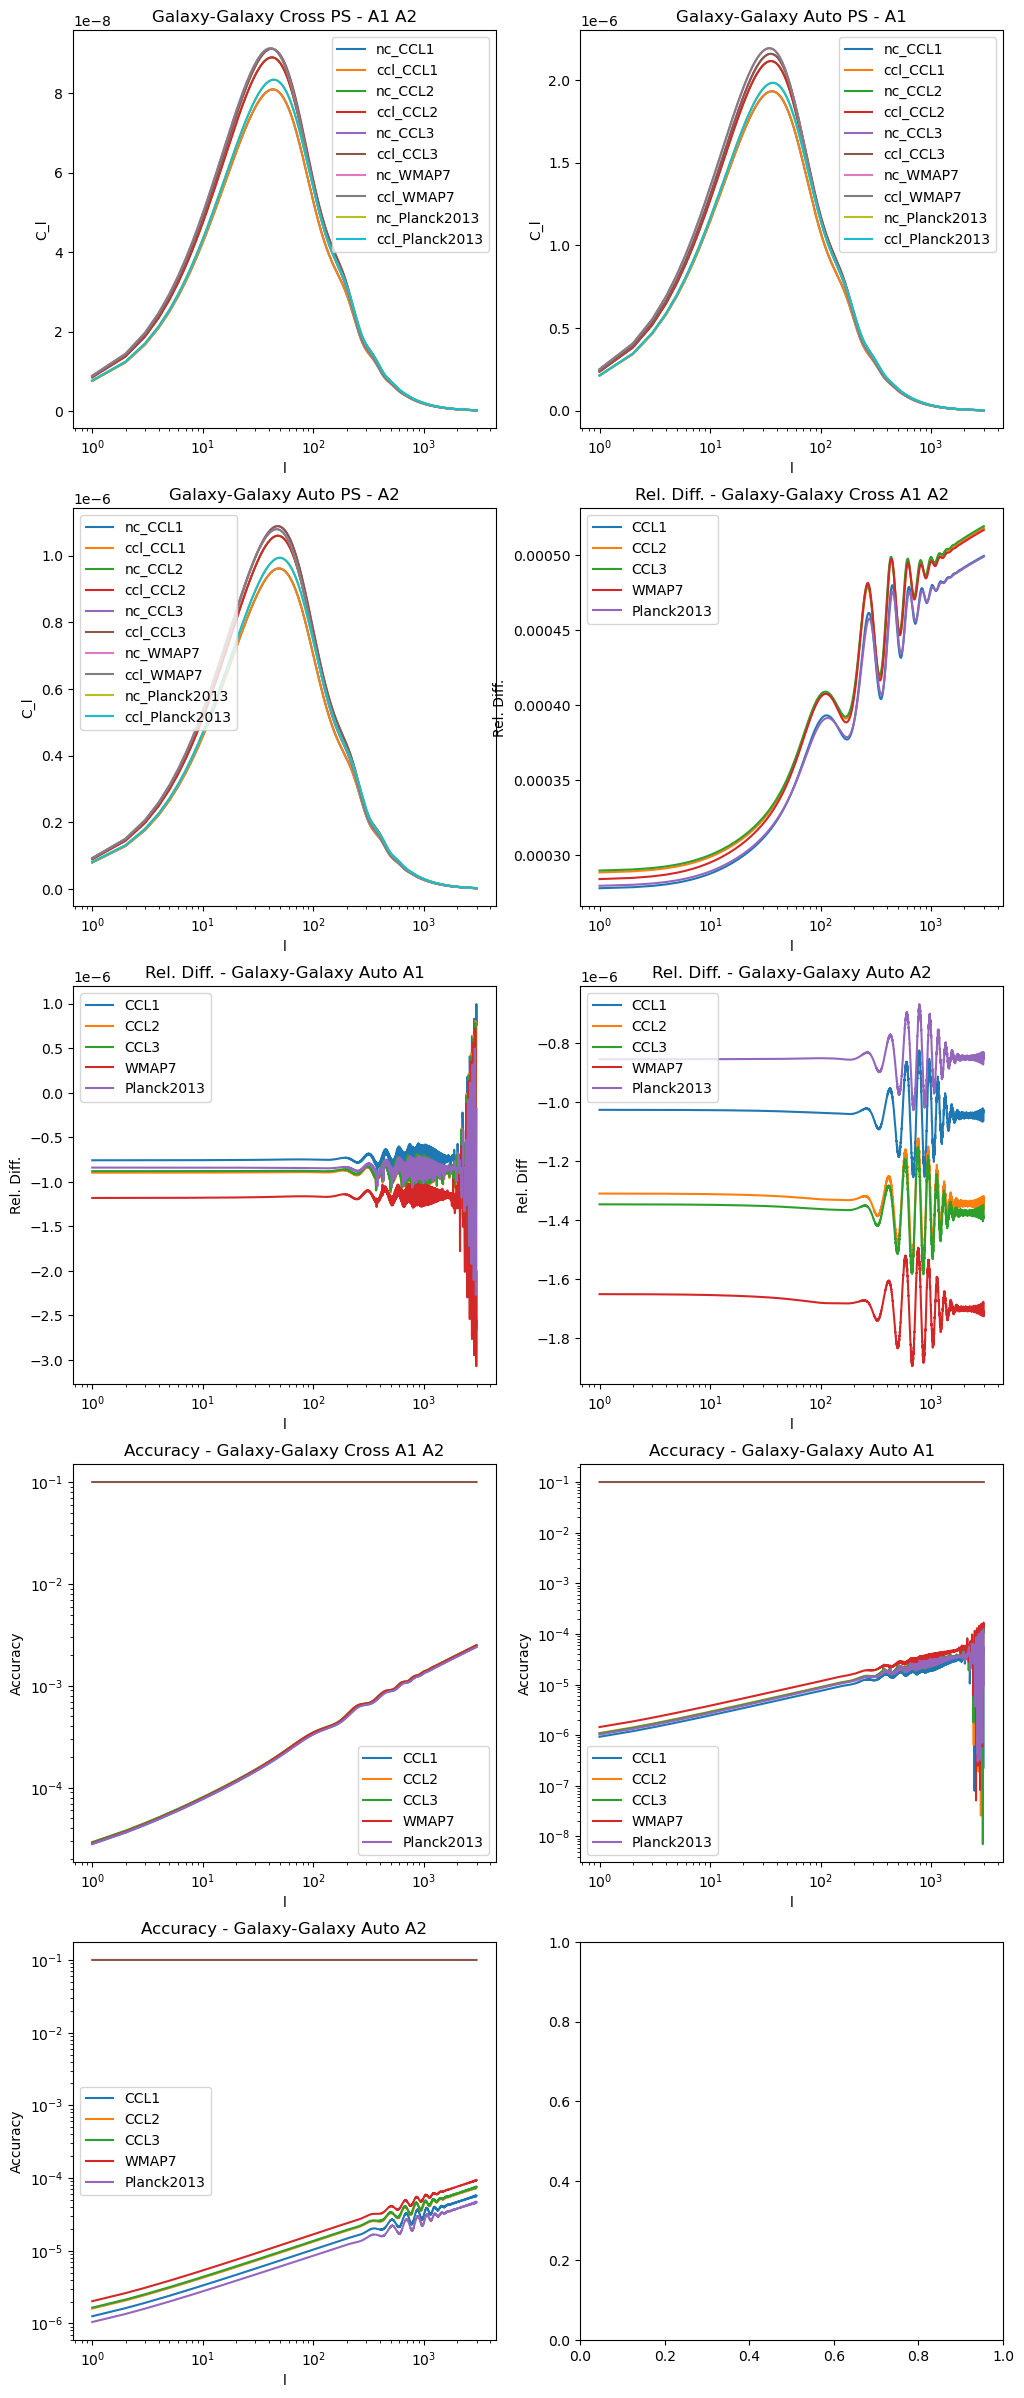

In [13]:
###### Defining some dictionaries to store some values ########
CCL_cl_cross_ana = {}
CCL_cl_auto1_ana = {}
CCL_cl_auto2_ana = {}
NC_cl_cross_ana = {}
NC_cl_auto1_ana = {}
NC_cl_auto2_ana = {}
REL_DIFF_cross_ana = {}
REL_DIFF_auto1_ana = {}
REL_DIFF_auto2_ana = {}
ACC_cross_ana = {}
ACC_auto1_ana = {}
ACC_auto2_ana = {}

###### Defining the figure
fig, axs = plt.subplots(5, 2, figsize=(12, 30))

###### Running the loop
i = 0
for cosmology in names:
    Omega_c = CCL_cosmologies[cosmology][0]
    Omega_b = CCL_cosmologies[cosmology][1]
    Omega_v = CCL_cosmologies[cosmology][2]
    h = CCL_cosmologies[cosmology][3]
    sigma8 = CCL_cosmologies[cosmology][4]
    n_s = CCL_cosmologies[cosmology][5]
    w0 = CCL_cosmologies[cosmology][6]
    wa = CCL_cosmologies[cosmology][7]
    Neff = CCL_cosmologies[cosmology][8]
    m_nu = CCL_cosmologies[cosmology][9]

    name = cosmology

    (
        CCL_cl_cross_ana[name],
        CCL_cl_auto1_ana[name],
        CCL_cl_auto2_ana[name],
        NC_cl_cross_ana[name],
        NC_cl_auto1_ana[name],
        NC_cl_auto2_ana[name],
        REL_DIFF_cross_ana[name],
        REL_DIFF_auto1_ana[name],
        REL_DIFF_auto2_ana[name],
        ACC_cross_ana[name],
        ACC_auto1_ana[name],
        ACC_auto2_ana[name],
    ) = compare_galaxy_galaxy_angular_cl(
        Omega_c,
        Omega_b,
        Omega_v,
        h,
        sigma8,
        n_s,
        w0,
        wa,
        Neff,
        m_nu,
        z1_ana,
        z2_ana,
        dndz1_ana,
        dndz2_ana,
        ells_ana,
    )

    axs[0, 0].plot(ells_ana, NC_cl_cross_ana[name], label="nc_" + name)
    axs[0, 0].plot(ells_ana, CCL_cl_cross_ana[name], label="ccl_" + name)

    axs[0, 1].plot(ells_ana, NC_cl_auto1_ana[name], label="nc_" + name)
    axs[0, 1].plot(ells_ana, CCL_cl_auto1_ana[name], label="ccl_" + name)

    axs[1, 0].plot(ells_ana, NC_cl_auto2_ana[name], label="nc_" + name)
    axs[1, 0].plot(ells_ana, CCL_cl_auto2_ana[name], label="ccl_" + name)

    axs[1, 1].plot(ells_ana, REL_DIFF_cross_ana[name], label=name)

    axs[2, 0].plot(ells_ana, REL_DIFF_auto1_ana[name], label=name)

    axs[2, 1].plot(ells_ana, REL_DIFF_auto2_ana[name], label=name)

    axs[3, 0].plot(ells_ana, ACC_cross_ana[name], label=name)

    axs[3, 1].plot(ells_ana, ACC_auto1_ana[name], label=name)

    axs[4, 0].plot(ells_ana, ACC_auto2_ana[name], label=name)

    if ACC_cross_ana[name].max() > 0.1:
        print(
            "A_acc_cross max "
            + name
            + " = "
            + str(ACC_cross_ana[name][ACC_cross_ana[name] > 0.1])
            + "\n"
        )
        print(
            "A_acc_cross max value position "
            + name
            + " = "
            + str(np.where(ACC_cross_ana[name] > 0.1)[0])
            + "\n"
        )
    if ACC_auto1_ana[name].max() > 0.1:
        print(
            "A_acc_auto1 max "
            + name
            + " = "
            + str(ACC_auto1_ana[name][ACC_auto1_ana[name] > 0.1])
            + "\n"
        )
        print(
            "A_acc_auto1 max value position "
            + name
            + " = "
            + str(np.where(ACC_auto1_ana[name] > 0.1)[0])
            + "\n"
        )
    if ACC_auto2_ana[name].max() > 0.1:
        print(
            "A_acc_auto2 max "
            + name
            + " = "
            + str(ACC_auto2_ana[name][ACC_auto2_ana[name] > 0.1])
            + "\n"
        )
        print(
            "A_acc_auto2 max value position "
            + name
            + " = "
            + str(np.where(ACC_auto2_ana[name] > 0.1)[0])
            + "\n"
        )

    i += 1

axs[0, 0].set_title("Galaxy-Galaxy Cross PS - A1 A2")
axs[0, 0].legend()
axs[0, 0].set(xlabel="l", ylabel="C_l")
axs[0, 0].set(xscale="log")

axs[0, 1].set_title("Galaxy-Galaxy Auto PS - A1")
axs[0, 1].legend()
axs[0, 1].set(xlabel="l", ylabel="C_l")
axs[0, 1].set(xscale="log")

axs[1, 0].set_title("Galaxy-Galaxy Auto PS - A2")
axs[1, 0].legend()
axs[1, 0].set(xlabel="l", ylabel="C_l")
axs[1, 0].set(xscale="log")

axs[1, 1].set_title("Rel. Diff. - Galaxy-Galaxy Cross A1 A2")
axs[1, 1].legend()
axs[1, 1].set(xlabel="l", ylabel="Rel. Diff.")
axs[1, 1].set(xscale="log")

axs[2, 0].set_title("Rel. Diff. - Galaxy-Galaxy Auto A1")
axs[2, 0].legend()
axs[2, 0].set(xlabel="l", ylabel="Rel. Diff.")
axs[2, 0].set(xscale="log")

axs[2, 1].set_title("Rel. Diff. - Galaxy-Galaxy Auto A2")
axs[2, 1].legend()
axs[2, 1].set(xlabel="l", ylabel="Rel. Diff")
axs[2, 1].set(xscale="log")

expected_acc_ana = np.empty(len(ells_ana))
expected_acc_ana.fill(0.1)

axs[3, 0].plot(ells_ana, expected_acc_ana)
axs[3, 0].set_title("Accuracy - Galaxy-Galaxy Cross A1 A2")
axs[3, 0].legend()
axs[3, 0].set(xlabel="l", ylabel="Accuracy")
axs[3, 0].set(xscale="log")
axs[3, 0].set(yscale="log")

axs[3, 1].plot(ells_ana, expected_acc_ana)
axs[3, 1].set_title("Accuracy - Galaxy-Galaxy Auto A1")
axs[3, 1].legend()
axs[3, 1].set(xlabel="l", ylabel="Accuracy")
axs[3, 1].set(xscale="log")
axs[3, 1].set(yscale="log")

axs[4, 0].plot(ells_ana, expected_acc_ana)
axs[4, 0].set_title("Accuracy - Galaxy-Galaxy Auto A2")
axs[4, 0].legend()
axs[4, 0].set(xlabel="l", ylabel="Accuracy")
axs[4, 0].set(xscale="log")
axs[4, 0].set(yscale="log")